In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/dataset.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
df.dtypes
df.shape[0]

In [ ]:
#one row is missing many values, so this drops that row
df = df.drop(labels = df[df.isna().any(axis=1)].index, axis = 0)

<ipython-input-35-91dbedfa8d57>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_popularity.index, y=genre_popularity.values, palette="viridis")


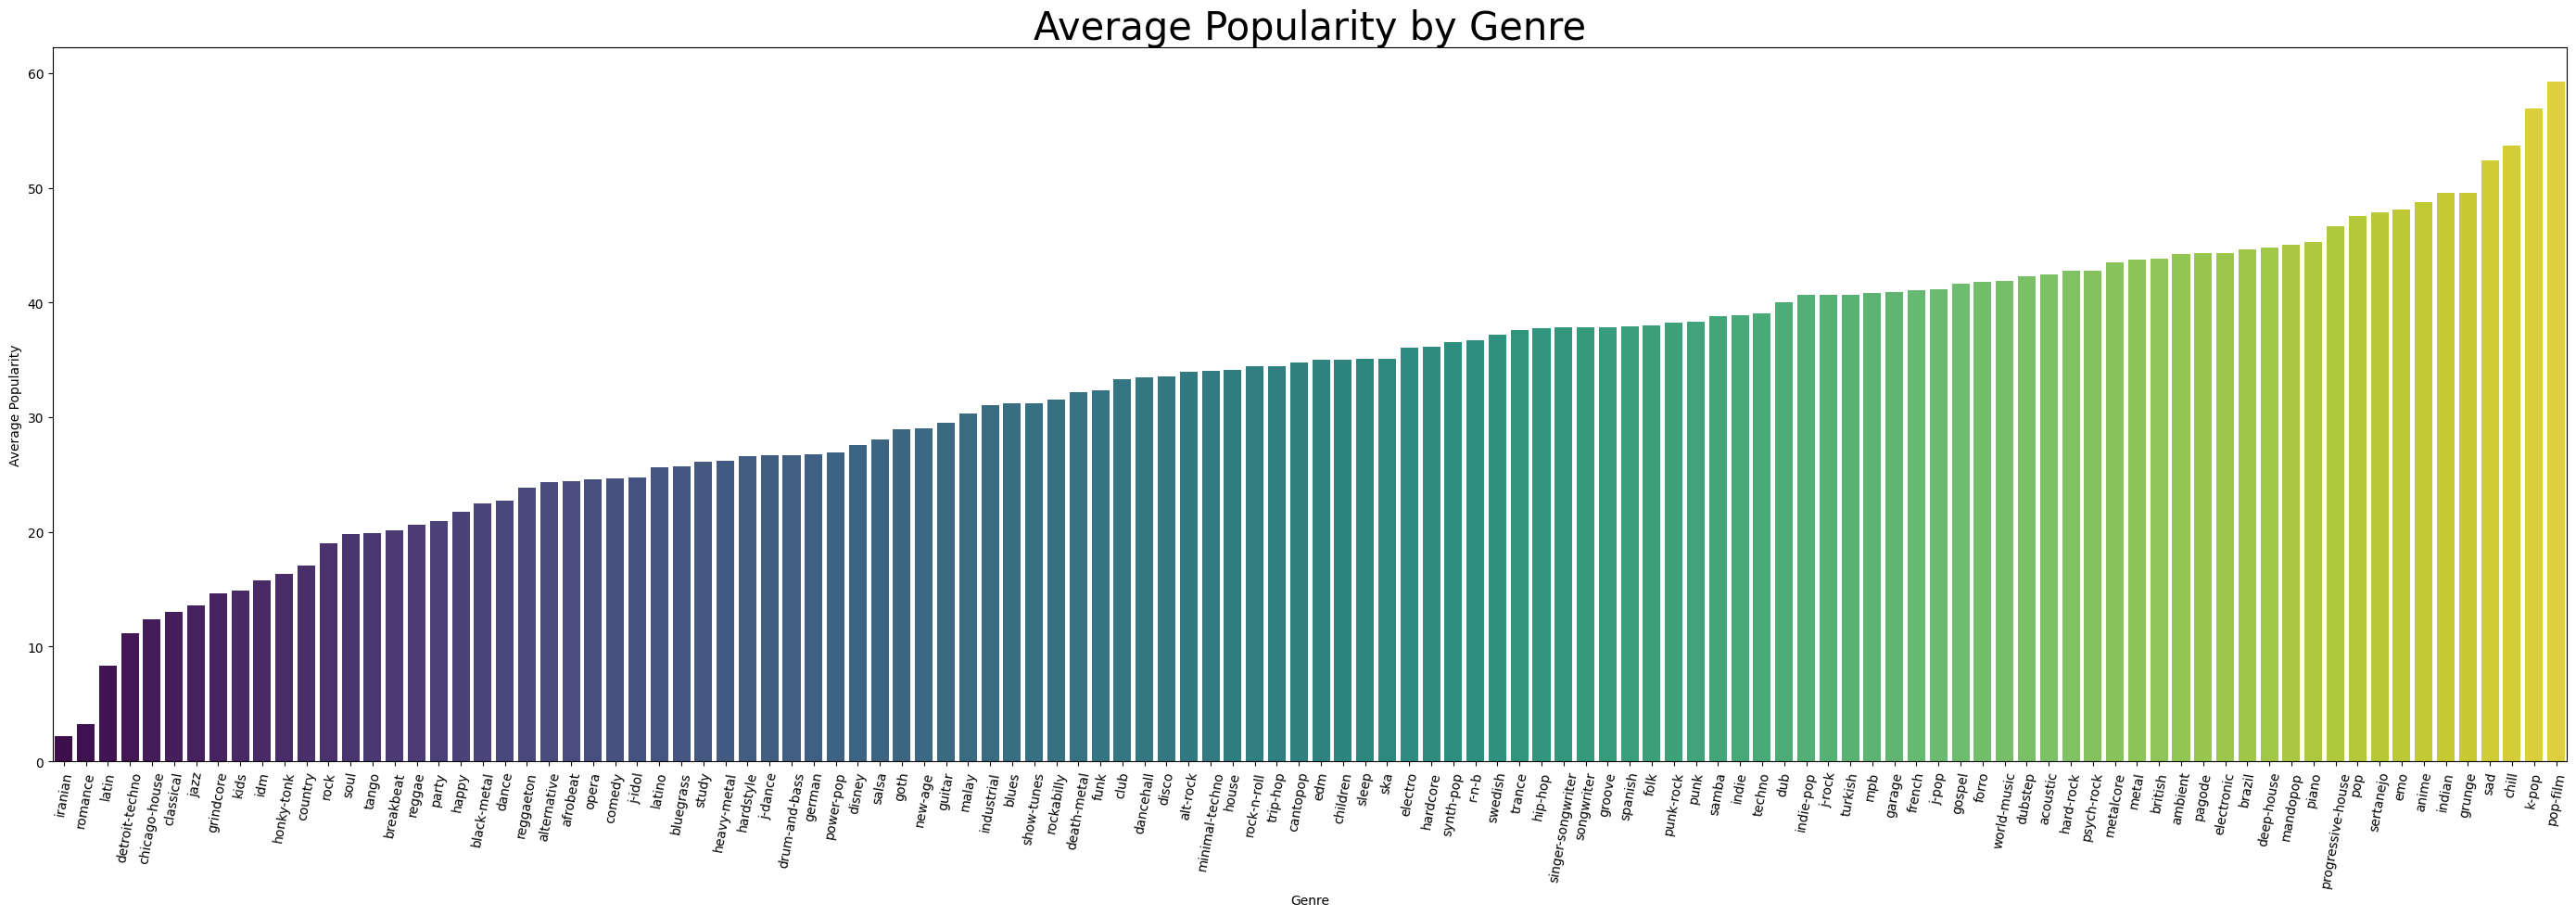

In [ ]:
genre_popularity = df.groupby('track_genre')['popularity'].mean().sort_values()

plt.figure(figsize=(35, 10))
sns.barplot(x=genre_popularity.index, y=genre_popularity.values, palette="viridis")
plt.xlabel("Genre")
plt.ylabel("Average Popularity")
plt.title("Average Popularity by Genre", fontsize=30)
plt.xticks(rotation= 80)
plt.show()

<ipython-input-36-7b16c3d68054>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre_popularity = df.groupby('song_length_category')['popularity'].mean().sort_values()
<ipython-input-36-7b16c3d68054>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_popularity.index, y=genre_popularity.values, palette="viridis")


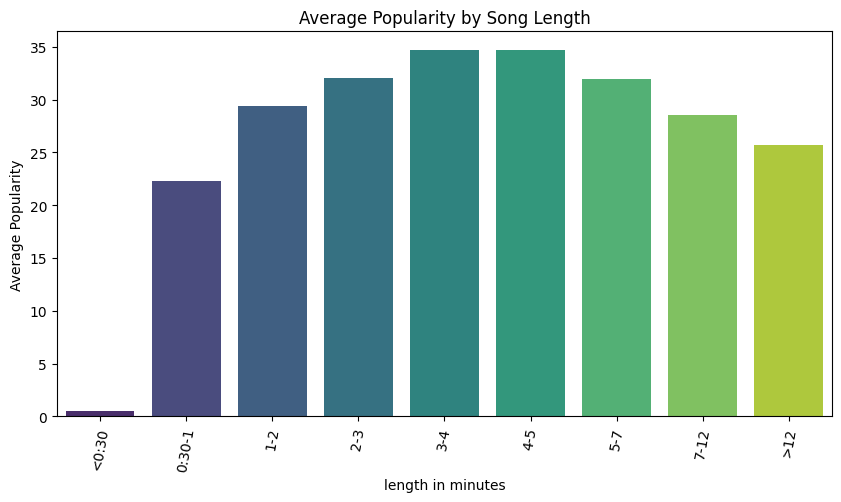

In [ ]:
bins = [0,         30000,    60000,120000, 180000, 240000,300000, 420000, 720000, float('inf')]  # Example bins (adjust as needed)
labels = ['<0:30', '0:30-1', '1-2','2-3','3-4','4-5','5-7','7-12','>12']

# Create the categorical 'song_length_category' column
df['song_length_category'] = pd.cut(df['duration_ms'], bins=bins, labels=labels, right=False)

# Display a few rows to verify the new column
#print(df[['duration_ms', 'song_length_category']].head(20))

genre_popularity = df.groupby('song_length_category')['popularity'].mean().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=genre_popularity.index, y=genre_popularity.values, palette="viridis")
plt.xlabel("length in minutes")
plt.ylabel("Average Popularity")
plt.title("Average Popularity by Song Length")
plt.xticks(rotation = 80)
plt.show()

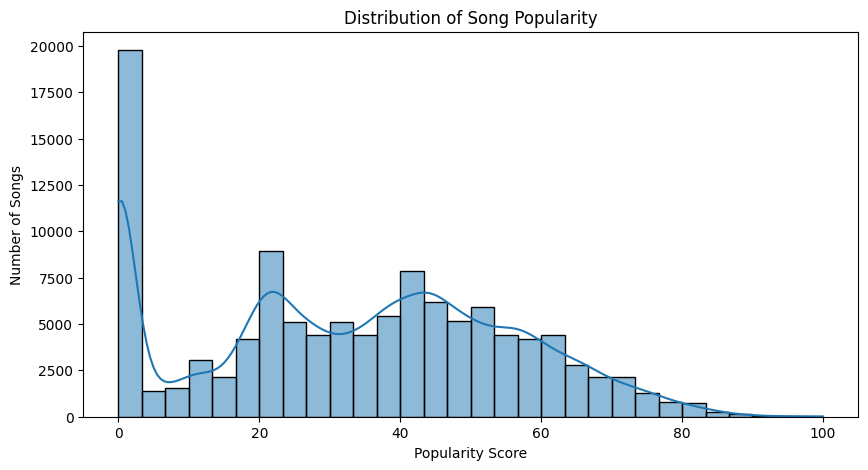

songs with popularity zero or one 18159
songs with popularity higher than one 97980


In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['popularity'], bins=30, kde=True)
plt.xlabel("Popularity Score")
plt.ylabel("Number of Songs")
plt.title("Distribution of Song Popularity")
plt.show()

zero_songs = df[df['popularity'] <= 1]
other_songs = df[df['popularity'] != 0]

print("songs with popularity zero or one", zero_songs.shape[0])
print("songs with popularity higher than one", other_songs.shape[0])

114,000 songs in dataset.
16,020 songs have popoularity 0 or 1.

To balance our dataset, we should decraese the amount of songs with popularity 1 or 0



In [ ]:
def binary_popularity(popularity):
       if 0 <= popularity <= 25:
          return 0
       elif 25 < popularity <= 100:
          return 1
       else:
          return -1  # Handle values outside the range if necessary

def explicitness(explicit):
  if explicit == 0:
    return 0
  else:
    return 1

df['binary_popularity'] = df['popularity'].apply(binary_popularity)
df['explicitness'] = df['explicit'].apply(explicitness)
#these are all numerical features
binary_df = df[['duration_ms',	'danceability', 'energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature', 'explicitness', 'key', 'mode', 'binary_popularity']]  # Select desired columns
binary_df.head()


,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,explicitness,key,mode,binary_popularity
0,230666,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0,1,0,1
1,149610,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0,1,1,1
2,210826,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0,0,1,1
3,201933,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0,0,1,1
4,198853,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0,2,1,1


In [ ]:
binary_df.corr()

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,explicitness,key,mode,binary_popularity
duration_ms,1.000000,-0.073435,0.058520,-0.003475,-0.062605,-0.103770,0.124364,0.010308,-0.154464,0.024356,0.018229,-0.065270,0.008123,-0.035581,-0.003666
danceability,-0.073435,1.000000,0.134325,0.259076,0.108625,-0.171531,-0.185608,-0.131620,0.477347,-0.050448,0.207219,0.122506,0.036470,-0.069224,0.042914
energy,0.058520,0.134325,1.000000,0.761690,0.142508,-0.733908,-0.181880,0.184795,0.258937,0.247852,0.187127,0.096954,0.048007,-0.078365,-0.001497
loudness,-0.003475,0.259076,0.761690,1.000000,0.060826,-0.589804,-0.433478,0.076897,0.279851,0.212447,0.191992,0.108587,0.038591,-0.041768,0.048291
speechiness,-0.062605,0.108625,0.142508,0.060826,1.000000,-0.002184,-0.089617,0.205218,0.036637,0.017274,-0.000011,0.307951,0.020419,-0.046535,-0.080336
acousticness,-0.103770,-0.171531,-0.733908,-0.589804,-0.002184,1.000000,0.104033,-0.020693,-0.107081,-0.208231,-0.176142,-0.094400,-0.040942,0.095568,-0.009112
instrumentalness,0.124364,-0.185608,-0.181880,-0.433478,-0.089617,0.104033,1.000000,-0.079896,-0.324310,-0.050328,-0.082580,-0.103405,-0.006821,-0.049961,-0.114337
liveness,0.010308,-0.131620,0.184795,0.076897,0.205218,-0.020693,-0.079896,1.000000,0.019093,0.000603,-0.023649,0.032547,-0.001597,0.014004,0.014268
valence,-0.154464,0.477347,0.258937,0.279851,0.036637,-0.107081,-0.324310,0.019093,1.000000,0.078269,0.133685,-0.003378,0.034099,0.021964,-0.001319
tempo,0.024356,-0.050448,0.247852,0.212447,0.017274,-0.208231,-0.050328,0.000603,0.078269,1.000000,0.066640,-0.002815,0.010914,0.000572,0.015448


While individually there is not a strong correlation

In [ ]:
def categorical_popularity(popularity):
       if 0 <= popularity <= 25:
          return 0
       elif 25 < popularity <= 50:
          return 1
       elif 50 < popularity <= 75:
          return 2
       elif 75 < popularity <= 100:
          return 3
       else:
          return -1


def explicitness(explicit):
  if explicit == 0:
    return 0
  else:
    return 1

df['categorical_popularity'] = df['popularity'].apply(categorical_popularity)
df['explicitness'] = df['explicit'].apply(explicitness)

categorical_df = df[['duration_ms',	'mode', 'key', 'explicitness', 'danceability', 'energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature', 'categorical_popularity']]  # Select desired columns
#categorical_df.head()

In [ ]:
#multi feature model (linear regression)
from sklearn.metrics import mean_squared_error
#multi feature model (linear regression)

X = df[['duration_ms','explicit','mode','key','danceability', 'energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']]
y = df['popularity']

#do linear regression for each feature individually

for feature in X.columns: #training accuracy
    X = df[[feature]]
    y = df['popularity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    model = LinearRegression().fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred_train)
    print(mse)

    '''
    training_accuracy = accuracy_score(y_pred_train, y_train)
    print('accuracy of X_train and y_train is :' , training_accuracy)

    #plot the graph
    plt.figure(figsize=(6, 4))
    plt.scatter(X_test, y_test, color='blue', label='Data')
    plt.plot(X_test, y_pred_train, color='red', label = "Predictions")
    plt.xlabel(feature)
    plt.ylabel("Popularity")
    plt.title(f'Simple Linear Regression for {feature}')
    plt.legend()
    plt.show()

    coefficient = model.coef_[0]
    intercept = model.intercept_
    #print("MSE: ", mse, "Coefficient: ", coefficient, "Intercept: ", intercept)
    print("\n")
  '''

#multi feature model (linear regression)
X = df[['duration_ms', 'explicit','mode', 'key', 'danceability', 'energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']]
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print("multiple feature accuracy: ",accuracy)


498.11921355491745
497.1852495337322
498.0438413272046
498.15939899618746
497.58950141479204
498.1623433003172
496.8603458281127
497.1290565289151
497.83695671607387
493.46311625658205
498.1407216468499
497.323683672143
498.0701041249256
497.63847096590837
multiple feature accuracy:  0.02133928016594755


In [ ]:
df.head()
#binary_df.corr()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,track_genre,song_length_category,binary_popularity,explicitness,categorical_popularity
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0.000001,0.3580,0.715,87.917,4,acoustic,3-4,1,0,2
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,0.000006,0.1010,0.267,77.489,4,acoustic,2-3,1,0,2
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,0.000000,0.1170,0.120,76.332,4,acoustic,3-4,1,0,2
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,0.000071,0.1320,0.143,181.740,3,acoustic,3-4,1,0,2
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,0.000000,0.0829,0.167,119.949,4,acoustic,3-4,1,0,3


In [ ]:
#other classificaion things(if we want to)

#using best few features can do logreg and SVC.
#figure out what else we can rly do w this proj cuz we may be relatively good.


#decision regressor model
#SVM w/Kernel bc its nonlinear data and not separable
from sklearn.svm import SVC
df = binary_df

X = df[['duration_ms','mode','key','danceability','loudness','speechiness','acousticness','instrumentalness', 'explicitness', 'liveness','valence']]
y = df['binary_popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
LG_y_pred = log_reg.predict(X_test)

print("LG Confusion Matrix: ")
print(confusion_matrix(LG_y_pred, y_test))
print("LG Accuracy score: ", accuracy_score(LG_y_pred, y_test))


model = SVC(kernel='rbf', max_iter = 1000000)
model.fit(X_train, y_train)
SVC_y_pred = model.predict(X_test)
accuracy = accuracy_score(SVC_y_pred, y_test)
print("SVC Confusion Matrix: ")
tn, fp, fn, tp = (confusion_matrix(SVC_y_pred, y_test).ravel())
print(tn, fp, fn, tp)
#print("SVC Accuracy score: ", accuracy_score(SVC_y_pred, y_test))
print("SVC F1 Score: ", f1_score(SVC_y_pred, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LG Confusion Matrix: 
[[  316   431]
 [14411 22462]]
LG Accuracy score:  0.6054758107389686


This shows as that our algorithm predicted everything as popular, even thouse that were not popular. 75% of our data had a popularity of above 50, hence our accuracy score being 75%, which is technically pretty good.

####what did we do wrong?

In [ ]:
df = categorical_df

X = df[['duration_ms','mode','key','danceability','loudness','speechiness','acousticness','instrumentalness', 'explicitness', 'liveness','valence']]
y = df['categorical_popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
LG_y_pred = log_reg.predict(X_test)

print("LG Confusion Matrix: ")
print(confusion_matrix(LG_y_pred, y_test))
print("LG Accuracy score: ", accuracy_score(LG_y_pred, y_test))


model = LinearSVC(loss="")
model.fit(X_train, y_train)
LSVC_y_pred = model.predict(X_test)
accuracy = accuracy_score(LSVC_y_pred, y_test)
print("LSVC Confusion Matrix: ")
print(confusion_matrix(LSVC_y_pred, y_test))
print("LSVC Accuracy score: ", accuracy_score(LSVC_y_pred, y_test))
print("SVC F1 Score: ", f1_score(SVC_y_pred, y_test))

In [ ]:
#Doing the SVC with lower the threshold for SVM features
#We are removing some of the features with a correlation to popularity lower than 0.04

reduced_binary_df = df[['danceability','loudness','speechiness','instrumentalness', 'binary_popularity']]  # Select desired columns
df = reduced_binary_df

#removing any instances of songs with the same level of danceability, loudness, speechiness, and instrumentalness
df.drop_duplicates()

X = df['danceability','loudness','speechiness','instrumentalness']
y = df['binary_popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
LG_y_pred = log_reg.predict(X_test)

print("LG Confusion Matrix: ")
print(confusion_matrix(LG_y_pred, y_test))
print("LG Accuracy score: ", accuracy_score(LG_y_pred, y_test))


model = LinearSVC(loss="")
model.fit(X_train, y_train)
LSVC_y_pred = model.predict(X_test)
accuracy = accuracy_score(LSVC_y_pred, y_test)
print("LSVC Confusion Matrix: ")
print(confusion_matrix(LSVC_y_pred, y_test))
print("LSVC Accuracy score: ", accuracy_score(LSVC_y_pred, y_test))
print("SVC F1 Score: ", f1_score(SVC_y_pred, y_test))


WHAT TO DO FROM NOW ON:
- Different variations of undersampling where we decrease songs of popularity 0/1 in various random manners